# Business Problem: Optimal Workplace Safety through Face Mask Detection
In the face of the global pandemic we've experienced in recent years, workplace safety has become more crucial than ever. The business problem to be addressed is how to enhance worker safety and health in work environments by ensuring compliance with face mask usage. 


**Objectives** 

- **1. Enhance Compliance:** Develop a face mask detection system that can boost worker compliance with face mask usage in the workplace.

- **2. Effective Monitoring:** Create a solution that enables effective monitoring of face mask usage across diverse environmental conditions and workplace locations.

- **3. Prevent Virus Spread:** Reduce the risk of virus transmission, such as COVID-19, by ensuring that all individuals in the workplace wear face masks properly.

- **4. Operational Efficiency:** Enhance operational efficiency by reducing the time required for manual compliance checks and ensuring uninterrupted operations due to face mask compliance.  

**Success Metrics**

- **1. Compliance Percentage:** Increase the percentage of worker compliance with face mask usage guidelines.

- **2. Response Time:** Reduce the response time in detecting face mask usage violations and providing alerts.

- **3. Virus Spread Prevention:** Reduce the number of virus infection cases in the workplace as a result of increased face mask compliance.

**Potential Solutions**
Implement a camera-based and deep learning algorithm-powered face mask detection system to ensure workplace safety and health, with automatic notification integration and real-time compliance monitoring. This solution can be adopted across various industries and work environments that require strict control over face mask usage to prevent virus spread.

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Import Libraries

In [ ]:
import os  # Provides functions for interacting with the operating system
import cv2  # OpenCV library for computer vision tasks
import random  # Provides functions for generating random numbers
import shutil  # Used for file and directory manipulation tasks
import torch  # Deep learning framework used for training the YOLO model
import pandas as pd  # Library for make DataFrame
import xml.etree.ElementTree as ET  # Used for parsing XML annotation files
import matplotlib.pyplot as plt  # Library for creating visualizations

from collections import defaultdict  # Creates dictionary-like objects with default values
from collections import Counter  # Used for counting occurrences of elements
from IPython.display import Image, display  # (Optional in standalone Python script) for displaying images

# Helper Functions

In [ ]:
import os
from collections import defaultdict
from xml.etree import ElementTree as ET


def count_images_per_class(annotation_folder: str) -> dict:
  """
  Counts the number of images belonging to each class in a dataset with XML annotations.

  Args:
      annotation_folder: Path to the directory containing the XML annotation files.

  Returns:
      A dictionary where keys are class names (strings) and values are counts (integers).
  """

  class_counts = defaultdict(int)

  for annotation_file in os.listdir(annotation_folder):
    if annotation_file.endswith(".xml"):
      annotation_path = os.path.join(annotation_folder, annotation_file)

      try:
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        for obj in root.findall("object"):
          class_name = obj.find("name").text
          class_counts[class_name] += 1
      except OSError as e:
        print(f"Error parsing annotation file '{annotation_path}': {e}")

  return class_counts

In [ ]:
def get_image_sizes(annotation_folder: str) -> list:
  """
  Extracts the width and height of images from their corresponding XML annotation files.

  Args:
      annotation_folder: Path to the directory containing the XML annotation files.

  Returns:
      A list of tuples, where each tuple represents the width and height of an image as integers.
  """

  image_sizes = []

  for annotation_file in os.listdir(annotation_folder):
    if annotation_file.endswith(".xml"):
      annotation_path = os.path.join(annotation_folder, annotation_file)

      try:
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        size = root.find("size")
        width = int(size.find("width").text)
        height = int(size.find("height").text)

        image_sizes.append((width, height))
      except OSError as e:
        print(f"Error parsing annotation file '{annotation_path}': {e}")

  return image_sizes

In [ ]:
import os
from xml.etree import ElementTree as ET


def parse_annotation(annotation_file: str) -> tuple:
  """
  Parses information from an XML annotation file for a single image.

  Args:
      annotation_file: Path to the XML annotation file.

  Returns:
      A tuple containing:
          - width (int): Width of the image.
          - height (int): Height of the image.
          - bounding_boxes (list): List of dictionaries representing bounding boxes.
              Each dictionary has the following keys:
                  - 'class' (str): Class name of the object in the bounding box.
                  - 'xmin' (int): X-coordinate of the top-left corner of the bounding box.
                  - 'ymin' (int): Y-coordinate of the top-left corner of the bounding box.
                  - 'xmax' (int): X-coordinate of the bottom-right corner of the bounding box.
                  - 'ymax' (int): Y-coordinate of the bottom-right corner of the bounding box.
  """

  if not os.path.isfile(annotation_file):
    raise FileNotFoundError(f"Annotation file not found: {annotation_file}")

  try:
    tree = ET.parse(annotation_file)
    root = tree.getroot()

    width = int(root.find("size").find("width").text)
    height = int(root.find("size").find("height").text)

    bounding_boxes = []
    for obj in root.findall("object"):
      bbox = obj.find("bndbox")
      xmin = int(bbox.find("xmin").text)
      ymin = int(bbox.find("ymin").text)
      xmax = int(bbox.find("xmax").text)
      ymax = int(bbox.find("ymax").text)
      class_name = obj.find("name").text
      bounding_boxes.append({"class": class_name, "xmin": xmin, "ymin": ymin, "xmax": xmax, "ymax": ymax})

    return width, height, bounding_boxes

  except (OSError, ET.ParseError) as e:
    print(f"Error parsing annotation file '{annotation_file}': {e}")
    return None  # Indicate parsing error

In [ ]:
import os
from xml.etree import ElementTree as ET


def xml_to_yolo(xml_path: str, txt_path: str, class_name_mapping: dict) -> None:
  """
  Converts annotations from an XML file to the YOLO format and saves them in a TXT file.

  Args:
      xml_path: Path to the XML annotation file.
      txt_path: Path to the output TXT file for YOLO annotations.
      class_name_mapping: Dictionary mapping XML class names to their corresponding YOLO class indices.
  """

  if not os.path.isfile(xml_path):
    raise FileNotFoundError(f"XML annotation file not found: {xml_path}")

  try:
    tree = ET.parse(xml_path)
    root = tree.getroot()

    width = int(root.find("size").find("width").text)
    height = int(root.find("size").find("height").text)

    objects = []
    for obj in root.findall("object"):
      class_name_xml = obj.find("name").text

      # Map XML class name to YOLO class index (handle missing classes)
      class_name_yolo = class_name_mapping.get(class_name_xml, 2)  # Default to 2 for unmapped classes

      bbox = obj.find("bndbox")
      xmin = int(bbox.find("xmin").text)
      ymin = int(bbox.find("ymin").text)
      xmax = int(bbox.find("xmax").text)
      ymax = int(bbox.find("ymax").text)

      # Calculate relative coordinates
      rel_x = (xmin + (xmax - xmin) / 2) / width
      rel_y = (ymin + (ymax - ymin) / 2) / height
      rel_w = (xmax - xmin) / width
      rel_h = (ymax - ymin) / height

      objects.append([class_name_yolo, rel_x, rel_y, rel_w, rel_h])

    # Write objects to YOLO format in the TXT file
    with open(txt_path, 'w') as txt_file:
      for obj in objects:
        txt_file.write(' '.join(map(str, obj)) + '\n')

  except (OSError, ET.ParseError) as e:
    print(f"Error parsing XML file '{xml_path}': {e}")

In [ ]:
import os


def count_images(folder_path: str) -> int:
  """
  Counts the number of image files (`.png` in this case) in a given folder.

  Args:
      folder_path: Path to the folder containing images.

  Returns:
      The number of image files found in the folder (integer).
  """

  if not os.path.isdir(folder_path):
    raise ValueError(f"Invalid path: '{folder_path}' is not a directory")

  image_count = 0
  for filename in os.listdir(folder_path):
    if filename.lower().endswith(".png"):  # Case-insensitive check for PNG extension
      image_count += 1

  return image_count

In [ ]:
import os


def get_image_files(folder_path: str) -> list:
  """
  Retrieves all file paths for images (`.png` in this case) within a given folder.

  Args:
      folder_path: Path to the folder containing images.

  Returns:
      A list of full paths to all image files found in the folder (strings).
  """

  if not os.path.isdir(folder_path):
    raise ValueError(f"Invalid path: '{folder_path}' is not a directory")

  image_files = []
  for filename in os.listdir(folder_path):
    if filename.lower().endswith(".png"):  # Case-insensitive check for PNG extension
      image_path = os.path.join(folder_path, filename)
      image_files.append(image_path)

  return image_files

# Data Exploration

## Dataset Analysis: Class-wise Image and Bounding Box Distribution and Image Sizes

In [ ]:
# Path ke folder anotasi # Path ke folder gambar
annotation_folder = '/content/drive/MyDrive/2/data/annotations'
image_folder = '/content/drive/MyDrive/2/data/images'

In [ ]:
import os
import xml.etree.ElementTree as ET
from collections import defaultdict


# Assuming this function is defined elsewhere (refer to previous improvements)
class_counts = count_images_per_class(annotation_folder)

# Check if image folder exists and handle potential errors
if not os.path.isdir(image_folder):
  raise ValueError(f"Image folder not found: {image_folder}")

# Filter image files based on extensions
image_files = [file for file in os.listdir(image_folder) if file.endswith('.jpg') or file.endswith('.png')]
total_images = len(image_files)

# Display information
print(f"Total number of images: {total_images}")
print("Number of annotations images for each class:")
for class_name, count in class_counts.items():
  print(f"- {class_name}: {count}")

Total number of images: 853
Number of annotations images for each class:
- with_mask: 3232
- without_mask: 717
- mask_weared_incorrect: 123


In [ ]:
import os
import xml.etree.ElementTree as ET
from collections import Counter


# Assuming this function is defined elsewhere (refer to previous improvements)
image_sizes = get_image_sizes(annotation_folder)

# Check if annotation folder exists and handle potential errors
if not os.path.isdir(annotation_folder):
  raise ValueError(f"Annotation folder not found: {annotation_folder}")

# Count total images using image files (consider using count_images if defined)
total_images = len([f for f in os.listdir(annotation_folder) if f.endswith(".xml")])
print(f"Total number of images: {total_images}\n")

# Count occurrences of each image size
size_counter = Counter(image_sizes)

# Display information
print("Top 5 most common image sizes:")
for size, count in size_counter.most_common(5):
  print(f"- Size: {size[0]}x{size[1]}, Count: {count}")

print("\nTop 5 least common image sizes:")
for size, count in size_counter.most_common()[-5:][::-1]:
  print(f"- Size: {size[0]}x{size[1]}, Count: {count}")

Total number of images: 853

Top 5 most common image sizes:
- Size: 301x400, Count: 184
- Size: 400x267, Count: 143
- Size: 400x225, Count: 88
- Size: 400x300, Count: 51
- Size: 400x226, Count: 50

Top 5 least common image sizes:
- Size: 400x306, Count: 1
- Size: 306x400, Count: 1
- Size: 400x188, Count: 1
- Size: 400x320, Count: 1
- Size: 400x381, Count: 1


# Data Visualization

## Visualizing Image Detection with Bounding Boxes

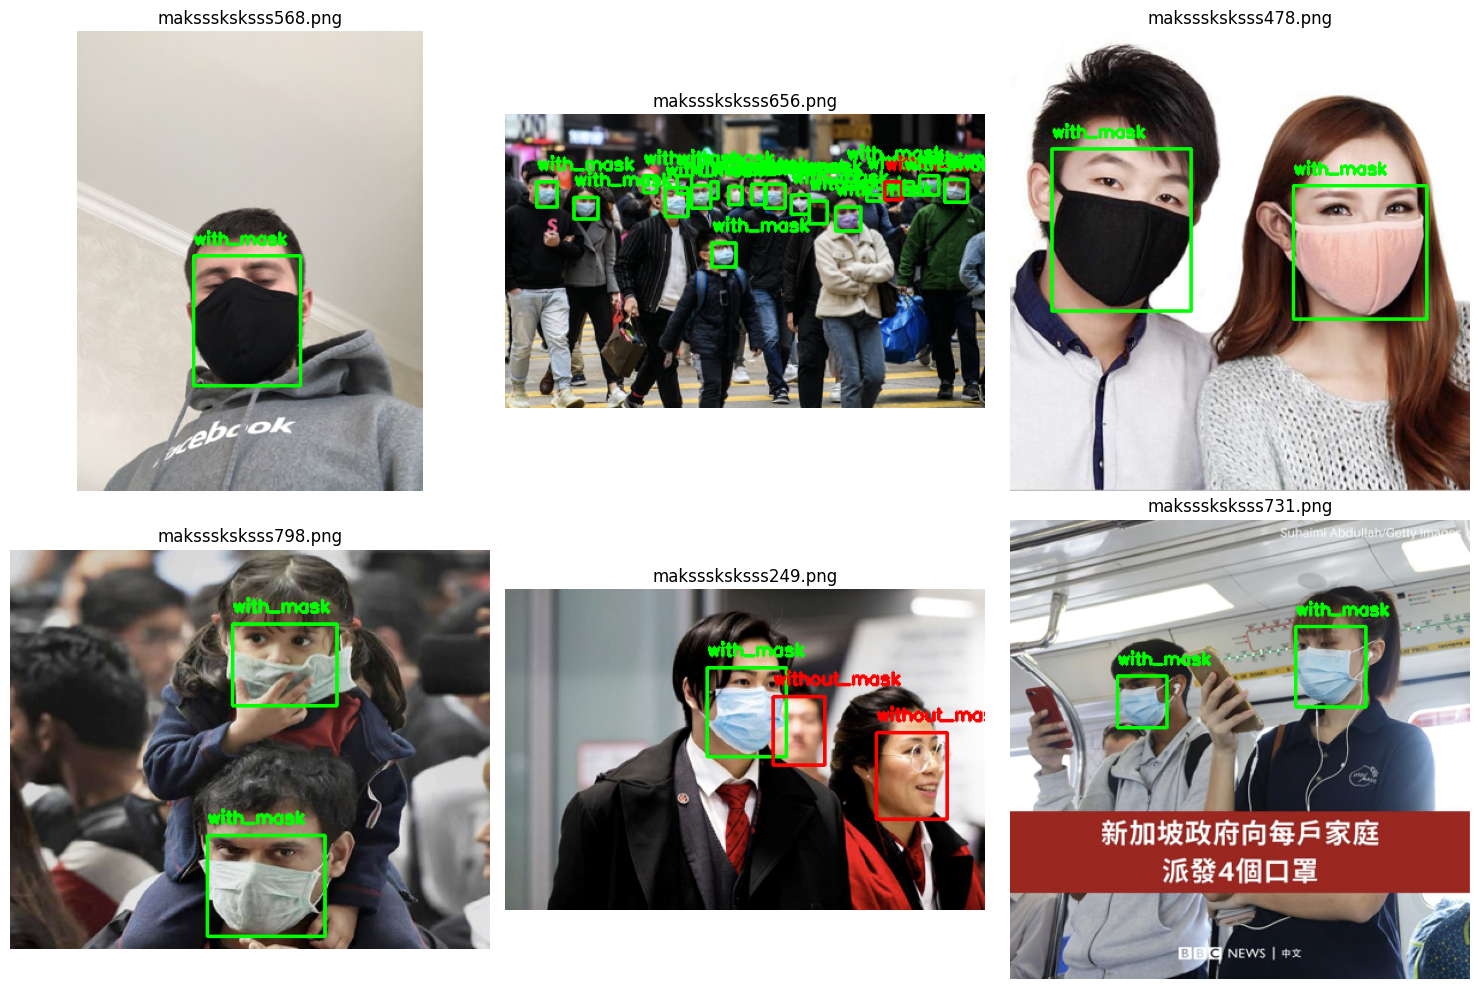

In [ ]:
import os
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import random

# Load dataset
image_annotations = {}
for image_file in os.listdir(image_folder):
    if image_file.endswith('.jpg') or image_file.endswith('.png'):
        image_path = os.path.join(image_folder, image_file)
        annotation_path = os.path.join(annotation_folder, os.path.splitext(image_file)[0] + '.xml')
        if os.path.exists(annotation_path):
            image_annotations[image_path] = annotation_path

# Select 6 random images
image_paths = list(image_annotations.keys())
random.shuffle(image_paths)
selected_image_paths = image_paths[:6]

# Initialize figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Counter to track image index
count = 0

# Iterate through the selected image paths
for i in range(2):
    for j in range(3):
        if count >= len(selected_image_paths):
            # Skip if no more images
            continue

        # Get the current image path and annotation path
        image_path = selected_image_paths[count]
        annotation_path = image_annotations[image_path]

        # Read the image and annotation
        image = cv2.imread(image_path)
        width, height, bounding_boxes = parse_annotation(annotation_path)

        # Draw bounding boxes and class labels with specific colors
        for bbox in bounding_boxes:
            if bbox['class'] == 'with_mask':
                color = (0, 255, 0)  # Green for 'with_mask'
            elif bbox['class'] == 'without_mask':
                color = (0, 0, 255)  # Red for 'with_nomask'
            else:
                color = (255, 0, 255)  # Purple for other classes

            cv2.rectangle(image, (bbox['xmin'], bbox['ymin']), (bbox['xmax'], bbox['ymax']), color, 2)
            cv2.putText(image, bbox['class'], (bbox['xmin'], bbox['ymin'] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Convert image from BGR to RGB for matplotlib
        image_rgb = image[:, :, ::-1]

        # Display the image on the subplot
        axes[i, j].imshow(image_rgb)

        # Set title as image filename
        axes[i, j].set_title(os.path.basename(image_path))

        # Turn off axes for cleaner visualization
        axes[i, j].axis('off')

        # Increment image counter
        count += 1

# Tight layout and display the plot
plt.tight_layout()
plt.show()

# Data Preprocessing

## YOLO Data Format Conversion from XML

In [ ]:
# Class name mapping from XML to YOLO (assuming these classes are present)
class_name_mapping = {
  'with_mask': 0,
  'without_mask': 1,
  'mask_weared_incorrect': 2,
}

# Create output folder for txt files (handle potential errors)
txt_folder = os.path.join("/content/drive/MyDrive/2/data/", 'labels')
try:
  os.makedirs(txt_folder, exist_ok=True)  # Create directory if it doesn't exist
except OSError as e:
  print(f"Error creating output folder: {e}")
  exit()

# Main processing loop
processed_files = 0
for image_file in os.listdir(image_folder):
  if image_file.endswith('.jpg') or image_file.endswith('.png'):
    image_path = os.path.join(image_folder, image_file)
    annotation_path = os.path.join(annotation_folder, os.path.splitext(image_file)[0] + '.xml')
    txt_path = os.path.join(txt_folder, os.path.splitext(image_file)[0] + '.txt')

    try:
      convert_xml_to_yolo(annotation_path, txt_path, class_name_mapping)
      processed_files += 1
      if processed_files % 100 == 0:
        print(f"Converted {processed_files} files to txt format")
    except (FileNotFoundError, OSError) as e:
      print(f"Error processing image '{image_file}': {e}")

Converted 100 files to txt format
Converted 200 files to txt format
Converted 300 files to txt format
Converted 400 files to txt format
Converted 500 files to txt format
Converted 600 files to txt format
Converted 700 files to txt format
Converted 800 files to txt format


## Number of Annotations per Class (Post-Conversion)


In [ ]:
import os

# Path to the folder containing txt files
txt_folder = '/content/drive/MyDrive/2/data/labels'

# List of class names (ensure it matches the mapping in your txt files)
list_class = ['with_mask', 'without_mask', 'mask_weared_incorrect']

# Initialize dictionary to store class counts
class_counts = {cls: 0 for cls in list_class}  # Dictionary comprehension for cleaner initialization

# Process each txt file
for filename in os.listdir(txt_folder):
    if filename.endswith('.txt'):
        file_path = os.path.join(txt_folder, filename)

        # Read the txt file lines
        with open(file_path, 'r') as f:
            lines = f.readlines()

        # Count bounding boxes for each class
        for line in lines:
            class_index, _, _, _, _ = line.strip().split(' ')
            try:
                class_index = int(class_index)  # Ensure valid integer index
                if 0 <= class_index < len(list_class):  # Check for valid class index range
                    class_counts[list_class[class_index]] += 1  # Increment count using class name
                else:
                    print(f"Warning: Unknown class index '{class_index}' found in file {filename}. Skipping.")
            except ValueError:
                print(f"Warning: Invalid class index format in file {filename}. Skipping line.")

# Print class counts
print("Number of annotations for each class after preprocessing:")
for class_name, count in class_counts.items():
    print(f"- {class_name}: {count}")

Number of annotations images for each class after preprocessing:
- with_mask: 3232
- without_mask: 717
- mask_weared_incorrect: 123


## Data Partitioning: Dividing the Dataset for Training, Validation, and Testing

In [ ]:
import os
import random
import shutil

# Path to the parent folder containing images and labels folders
parent_folder = '/content/drive/MyDrive/2/data'  # Update this path if needed

# Get image file paths from the images folder
image_folder = os.path.join(parent_folder, 'images')  # Update path if images are elsewhere
image_files = get_image_files(image_folder)


# Split data into 80% train, 10% val, and 10% test
random.shuffle(image_files)
train_split = 0.8
val_split = 0.1
test_split = 0.1

num_train = int(len(image_files) * train_split)
num_val = int(len(image_files) * val_split)
num_test = int(len(image_files) * test_split)

train_images = image_files[:num_train]
val_images = image_files[num_train:num_train + num_val]
test_images = image_files[-num_test:]

# Create train, val, and test folders within the current working directory (temporary)
train_folder = 'train'  # Change folder names as desired
val_folder = 'val'
test_folder = 'test'

# Create subfolders for images and labels within each train/val/test folder
if not os.path.exists(train_folder):
    os.makedirs(train_folder)
    os.makedirs(os.path.join(train_folder, 'images'))
    os.makedirs(os.path.join(train_folder, 'labels'))

if not os.path.exists(val_folder):
    os.makedirs(val_folder)
    os.makedirs(os.path.join(val_folder, 'images'))
    os.makedirs(os.path.join(val_folder, 'labels'))

if not os.path.exists(test_folder):
    os.makedirs(test_folder)
    os.makedirs(os.path.join(test_folder, 'images'))
    os.makedirs(os.path.join(test_folder, 'labels'))

# Move images and corresponding labels to respective folders (temporary)
for image_path in train_images:
    image_filename = os.path.basename(image_path)
    label_path = image_path.replace('images', 'labels').replace(image_filename, image_filename.replace('.png', '.txt'))

    shutil.copyfile(image_path, os.path.join(train_folder, 'images', image_filename))
    shutil.copyfile(label_path, os.path.join(train_folder, 'labels', image_filename.replace('.png', '.txt')))

for image_path in val_images:
    image_filename = os.path.basename(image_path)
    label_path = image_path.replace('images', 'labels').replace(image_filename, image_filename.replace('.png', '.txt'))

    shutil.copyfile(image_path, os.path.join(val_folder, 'images', image_filename))
    shutil.copyfile(label_path, os.path.join(val_folder, 'labels', image_filename.replace('.png', '.txt')))

for image_path in test_images:
    image_filename = os.path.basename(image_path)
    label_path = image_path.replace('images', 'labels').replace(image_filename, image_filename.replace('.png', '.txt'))

    shutil.copyfile(image_path, os.path.join(test_folder, 'images', image_filename))
    shutil.copyfile(label_path, os.path.join(test_folder, 'labels', image_filename.replace('.png', '.txt')))

# Move the split folders to the desired parent_folder
final_parent_folder = '/content/drive/MyDrive/2/my_dataset'  # Update this path if needed

if not os.path.exists(final_parent_folder):
    os.makedirs(final_parent_folder)

for folder in [train_folder, val_folder, test_folder]:
    shutil.move(folder, os.path.join(final_parent_folder, folder))

print("Dataset split complete")

Dataset split complete


## Image Distribution After Split

In [ ]:
# Count images in each folder
train_folder = os.path.join(final_parent_folder, 'train', 'images')
val_folder = os.path.join(final_parent_folder, 'val', 'images')
test_folder = os.path.join(final_parent_folder, 'test', 'images')

num_train_images = count_images(train_folder)
num_val_images = count_images(val_folder)
num_test_images = count_images(test_folder)

# Print image counts
print(f"Number of images in train folder: {num_train_images}")
print(f"Number of images in val folder: {num_val_images}")
print(f"Number of images in test folder: {num_test_images}")

Number of images in train folder: 684
Number of images in val folder: 85
Number of images in test folder: 85


# Model Training

## Model Training Configuration:

In [ ]:
!echo "train: ../drive/MyDrive/2/my_dataset/train" >> /content/drive/MyDrive/2/my_dataset/data.yaml
!echo "val:   ../drive/MyDrive/2/my_dataset/val" >> /content/drive/MyDrive/2/my_dataset/data.yaml
!echo "test:   ../drive/MyDrive/2/my_dataset/test" >> /content/drive/MyDrive/2/my_dataset/data.yaml
!echo "" >> /content/drive/MyDrive/2/my_dataset/data.yaml
!echo "nc : 3" >> /content/drive/MyDrive/2/my_dataset/data.yaml
!echo "names: ['with_mask', 'without_mask', 'mask_weared_incorrect']" >> /content/drive/MyDrive/2/my_dataset/data.yaml

!cat /content/drive/MyDrive/2/my_dataset/data.yaml

train: ../drive/MyDrive/2/my_dataset/train
val:   ../drive/MyDrive/2/my_dataset/val
test:   ../drive/MyDrive/2/my_dataset/test

nc : 3
names: ['with_mask', 'without_mask', 'mask_weared_incorrect']


In [ ]:
# Training parameters
BATCH_SIZE = 32  # Images per training iteration
IMGSZ = 400  # Image size for model input
EPOCHS = 50  # Number of training passes through the dataset
PATIENCE = 5  # Epochs to wait for improvement before stopping

# Training configuration
OPTIMIZER = "SGD"  # Optimization algorithm for weight updates

# Data and project paths
PATH_YAML = '/content/drive/MyDrive/2/my_dataset/data.yaml'  # Dataset information (YAML)
PROJECT_PATH = "/content/drive/MyDrive/2/verihubs/model"  # Project directory

# Additional hyperparameters
HYPERPARAMETER = "data/hyps/hyp.scratch-low.yaml"  # Additional training settings (YAML)

## Model Selection:

### For YOLOv5:

#### Select YOLOv5 Variant:

In [ ]:
# clone yolov5 model
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
!pip install -r requirements.txt  # install

Cloning into 'yolov5'...
remote: Enumerating objects: 16582, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 16582 (delta 30), reused 39 (delta 18), pack-reused 16522
Receiving objects: 100% (16582/16582), 15.13 MiB | 22.00 MiB/s, done.
Resolving deltas: 100% (11387/11387), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.4/756.4 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-n

#### Option: yolov5n

In [ ]:
# Start Training
!python train.py --img {IMGSZ} --batch {BATCH_SIZE}  --epochs {EPOCHS} --data {PATH_YAML} --weights yolov5n.pt --patience {PATIENCE} --project {PROJECT_PATH} --name "yolov5n" --hyp {HYPERPARAMETER} --optimizer {OPTIMIZER} --cache

2024-05-09 15:26:36.040329: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 15:26:36.040383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 15:26:36.042314: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5n.pt, cfg=, data=/content/drive/MyDrive/2/my_dataset/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=32, imgsz=400, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_s

In [ ]:
# validation
!python val.py --batch {BATCH_SIZE} --task "train" --data {PATH_YAML} --weights '{PROJECT_PATH}/yolov5n/weights/best.pt' --img {IMGSZ}

val: data=/content/drive/MyDrive/2/my_dataset/data.yaml, weights=['/content/drive/MyDrive/2/verihubs/model/yolov5n/weights/best.pt'], batch_size=32, imgsz=400, conf_thres=0.001, iou_thres=0.6, max_det=300, task=train, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-307-g920c721e Python-3.10.12 torch-2.2.1+cu121 CPU

Fusing layers... 
Model summary: 157 layers, 1763224 parameters, 0 gradients, 4.1 GFLOPs
WARNING ⚠️ --img-size 400 must be multiple of max stride 32, updating to 416
100% 755k/755k [00:00<00:00, 17.7MB/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
train: Scanning /content/drive/MyDrive/2/my_dataset/train/labels... 684 imag

In [ ]:
# validation with test Data
!python val.py --batch {BATCH_SIZE} --task "test" --data {PATH_YAML} --weights '{PROJECT_PATH}/yolov5n/weights/best.pt'  --img {IMGSZ}

val: data=/content/drive/MyDrive/2/my_dataset/data.yaml, weights=['/content/drive/MyDrive/2/verihubs/model/yolov5n/weights/best.pt'], batch_size=32, imgsz=400, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-307-g920c721e Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)

Fusing layers... 
Model summary: 157 layers, 1763224 parameters, 0 gradients, 4.1 GFLOPs
WARNING ⚠️ --img-size 400 must be multiple of max stride 32, updating to 416
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
test: Scanning /content/drive/MyDrive/2/my_dataset/test/labels... 85 images, 0 backgrounds,

#### Option: yolov5s

In [ ]:
# Start traning
!python train.py --img {IMGSZ} --batch {BATCH_SIZE} --epochs {EPOCHS} --data {PATH_YAML} --weights yolov5s.pt --patience 5 --project {PROJECT_PATH} --name "yolov5s" --hyp {HYPERPARAMETER} --optimizer {OPTIMIZER} --cache

2024-05-09 15:30:59.885119: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 15:30:59.885166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 15:30:59.887089: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=/content/drive/MyDrive/2/my_dataset/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=32, imgsz=400, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_s

In [ ]:
# validation
!python val.py --batch {BATCH_SIZE} --task "train" --data {PATH_YAML} --weights '{PROJECT_PATH}/yolov5s/weights/best.pt'  --img {IMGSZ}

val: data=/content/drive/MyDrive/2/my_dataset/data.yaml, weights=['/content/drive/MyDrive/2/verihubs/model/yolov5s/weights/best.pt'], batch_size=32, imgsz=400, conf_thres=0.001, iou_thres=0.6, max_det=300, task=train, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-307-g920c721e Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
WARNING ⚠️ --img-size 400 must be multiple of max stride 32, updating to 416
train: Scanning /content/drive/MyDrive/2/my_dataset/train/labels.cache... 684 images, 0 backgrounds, 0 corrupt: 100% 684/684 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this wi

In [ ]:
# validation with test Data
!python val.py --batch {BATCH_SIZE} --task "test" --data {PATH_YAML} --weights '{PROJECT_PATH}/yolov5s/weights/best.pt'  --img {IMGSZ}

val: data=/content/drive/MyDrive/2/my_dataset/data.yaml, weights=['/content/drive/MyDrive/2/verihubs/model/yolov5s/weights/best.pt'], batch_size=32, imgsz=400, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-307-g920c721e Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
WARNING ⚠️ --img-size 400 must be multiple of max stride 32, updating to 416
test: Scanning /content/drive/MyDrive/2/my_dataset/test/labels.cache... 85 images, 0 backgrounds, 0 corrupt: 100% 85/85 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will lik

#### Option: yolov5m

In [ ]:
# Start traning
!python train.py --img {IMGSZ} --batch {BATCH_SIZE} --epochs {EPOCHS} --data {PATH_YAML} --weights yolov5m.pt --patience {PATIENCE} --project {PROJECT_PATH} --name "yolov5m" --hyp {HYPERPARAMETER} --optimizer {OPTIMIZER} --cache

2024-05-09 15:35:17.279078: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 15:35:17.279122: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 15:35:17.280962: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5m.pt, cfg=, data=/content/drive/MyDrive/2/my_dataset/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=32, imgsz=400, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_s

In [ ]:
# validation
!python val.py --batch {BATCH_SIZE} --task "train" --data {PATH_YAML} --weights '{PROJECT_PATH}/yolov5m/weights/best.pt'  --img {IMGSZ}

val: data=/content/drive/MyDrive/2/my_dataset/data.yaml, weights=['/content/drive/MyDrive/2/verihubs/model/yolov5m/weights/best.pt'], batch_size=32, imgsz=400, conf_thres=0.001, iou_thres=0.6, max_det=300, task=train, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-307-g920c721e Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)

Fusing layers... 
Model summary: 212 layers, 20861016 parameters, 0 gradients, 47.9 GFLOPs
WARNING ⚠️ --img-size 400 must be multiple of max stride 32, updating to 416
train: Scanning /content/drive/MyDrive/2/my_dataset/train/labels.cache... 684 images, 0 backgrounds, 0 corrupt: 100% 684/684 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this w

In [ ]:
# validation with test Data
!python val.py --batch {BATCH_SIZE} --task "test" --data {PATH_YAML} --weights '{PROJECT_PATH}/yolov5m/weights/best.pt'  --img {IMGSZ}

val: data=/content/drive/MyDrive/2/my_dataset/data.yaml, weights=['/content/drive/MyDrive/2/verihubs/model/yolov5m/weights/best.pt'], batch_size=32, imgsz=400, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-307-g920c721e Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)

Fusing layers... 
Model summary: 212 layers, 20861016 parameters, 0 gradients, 47.9 GFLOPs
WARNING ⚠️ --img-size 400 must be multiple of max stride 32, updating to 416
test: Scanning /content/drive/MyDrive/2/my_dataset/test/labels.cache... 85 images, 0 backgrounds, 0 corrupt: 100% 85/85 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will li

#### Option: yolov5l

In [ ]:
# Start traning
!python train.py --img {IMGSZ} --batch {BATCH_SIZE} --epochs {EPOCHS} --data {PATH_YAML} --weights yolov5l.pt --patience {PATIENCE} --project {PROJECT_PATH} --name "yolov5l" --hyp {HYPERPARAMETER} --optimizer {OPTIMIZER} --cache

2024-05-09 15:40:41.102919: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 15:40:41.102971: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 15:40:41.104939: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5l.pt, cfg=, data=/content/drive/MyDrive/2/my_dataset/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=32, imgsz=400, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_s

In [ ]:
# validation
!python val.py --batch {BATCH_SIZE} --task "train" --data {PATH_YAML} --weights '{PROJECT_PATH}/yolov5l/weights/best.pt'  --img {IMGSZ}

val: data=/content/drive/MyDrive/2/my_dataset/data.yaml, weights=['/content/drive/MyDrive/2/verihubs/model/yolov5l/weights/best.pt'], batch_size=32, imgsz=400, conf_thres=0.001, iou_thres=0.6, max_det=300, task=train, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-307-g920c721e Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)

Fusing layers... 
Model summary: 267 layers, 46119048 parameters, 0 gradients, 107.7 GFLOPs
WARNING ⚠️ --img-size 400 must be multiple of max stride 32, updating to 416
train: Scanning /content/drive/MyDrive/2/my_dataset/train/labels.cache... 684 images, 0 backgrounds, 0 corrupt: 100% 684/684 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this 

In [ ]:
# validation with test Data
!python val.py --batch {BATCH_SIZE} --task "test" --data {PATH_YAML} --weights '{PROJECT_PATH}/yolov5l/weights/best.pt'  --img {IMGSZ}

val: data=/content/drive/MyDrive/2/my_dataset/data.yaml, weights=['/content/drive/MyDrive/2/verihubs/model/yolov5l/weights/best.pt'], batch_size=32, imgsz=400, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-307-g920c721e Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)

Fusing layers... 
Model summary: 267 layers, 46119048 parameters, 0 gradients, 107.7 GFLOPs
WARNING ⚠️ --img-size 400 must be multiple of max stride 32, updating to 416
test: Scanning /content/drive/MyDrive/2/my_dataset/test/labels.cache... 85 images, 0 backgrounds, 0 corrupt: 100% 85/85 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will l

#### Option: yolov5x

In [ ]:
# Start traning
!python train.py --img {IMGSZ} --batch {BATCH_SIZE} --epochs {EPOCHS} --data {PATH_YAML} --weights yolov5x.pt --patience {PATIENCE} --project {PROJECT_PATH} --name "yolov5x" --hyp {HYPERPARAMETER} --optimizer {OPTIMIZER} --cache

2024-05-09 15:48:35.972345: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 15:48:35.972403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 15:48:35.974271: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5x.pt, cfg=, data=/content/drive/MyDrive/2/my_dataset/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=32, imgsz=400, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_s

In [ ]:
# validation
!python val.py --batch {BATCH_SIZE} --task "train" --data {PATH_YAML} --weights '{PROJECT_PATH}/yolov5x/weights/best.pt'  --img {IMGSZ}

val: data=/content/drive/MyDrive/2/my_dataset/data.yaml, weights=['/content/drive/MyDrive/2/verihubs/model/yolov5x/weights/best.pt'], batch_size=32, imgsz=400, conf_thres=0.001, iou_thres=0.6, max_det=300, task=train, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-307-g920c721e Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)

Fusing layers... 
Model summary: 322 layers, 86186872 parameters, 0 gradients, 203.8 GFLOPs
WARNING ⚠️ --img-size 400 must be multiple of max stride 32, updating to 416
train: Scanning /content/drive/MyDrive/2/my_dataset/train/labels.cache... 684 images, 0 backgrounds, 0 corrupt: 100% 684/684 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this 

In [ ]:
# validation with test Data
!python val.py --batch {BATCH_SIZE} --task "test" --data {PATH_YAML} --weights '{PROJECT_PATH}/yolov5x/weights/best.pt'  --img {IMGSZ}

val: data=/content/drive/MyDrive/2/my_dataset/data.yaml, weights=['/content/drive/MyDrive/2/verihubs/model/yolov5x/weights/best.pt'], batch_size=32, imgsz=400, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-307-g920c721e Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)

Fusing layers... 
Model summary: 322 layers, 86186872 parameters, 0 gradients, 203.8 GFLOPs
WARNING ⚠️ --img-size 400 must be multiple of max stride 32, updating to 416
test: Scanning /content/drive/MyDrive/2/my_dataset/test/labels.cache... 85 images, 0 backgrounds, 0 corrupt: 100% 85/85 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will l

## For YOLOv8

### Select YOLOv8 Variant:

In [ ]:
# setup yolov8 model
!pip install ultralytics

In [ ]:
import ultralytics # Import the ultralytics library for YOLO model functionalities
from ultralytics import YOLO # Import the YOLO class from ultralytics for working with YOLOv8 models

#### Option: yolov8n

In [ ]:
# Start Training
!yolo task=detect mode=train \
model=yolov8n.pt data={PATH_YAML} \
epochs={EPOCHS} imgsz={IMGSZ} plots=True cache=True optimizer="auto" batch={BATCH_SIZE} \
patience={PATIENCE} project={PROJECT_PATH} name="yolov8n"

Ultralytics YOLOv8.2.11 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/2/my_dataset/data.yaml, epochs=50, time=None, patience=5, batch=32, imgsz=400, save=True, save_period=-1, cache=True, device=None, workers=8, project=/content/drive/MyDrive/2/verihubs/model, name=yolov8n, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, sa

In [ ]:
!yolo task=detect mode=val model="{PROJECT_PATH}/yolov8n/weights/best.pt" data={PATH_YAML} imgsz={IMGSZ} batch={BATCH_SIZE} split=train

WARNING ⚠️ imgsz=[400] must be multiple of max stride 32, updating to [416]
Ultralytics YOLOv8.2.12 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/drive/MyDrive/2/my_dataset/train/labels... 684 images, 0 backgrounds, 0 corrupt: 100% 684/684 [00:11<00:00, 57.10it/s]
val: New cache created: /content/drive/MyDrive/2/my_dataset/train/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50% 11/22 [00:45<00:42,  3.85s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 22/22 [01:30<00:00,  4.09s/it]
                   all        684       3210      0.754      0.654      0.721      0.478
             with_mask        684       2596      0.907       0.87      0.925      0.626
          without_mask        684

In [ ]:
# validation with test Data
!yolo task=detect mode=val model="{PROJECT_PATH}/yolov8n/weights/best.pt" data={PATH_YAML} imgsz={IMGSZ} batch={BATCH_SIZE} split=test

WARNING ⚠️ imgsz=[400] must be multiple of max stride 32, updating to [416]
Ultralytics YOLOv8.2.11 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/drive/MyDrive/2/my_dataset/test/labels.cache... 85 images, 0 backgrounds, 0 corrupt: 100% 85/85 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 3/3 [00:05<00:00,  1.88s/it]
                   all         85        459      0.723      0.562      0.625       0.41
             with_mask         85        356      0.885      0.781      0.859      0.577
          without_mask         85         93      0.925      0.505      0.713      0.437
 mask_weared_incorrect         85         10      0.359        0.4      0.303      0.216
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 26.0ms postprocess per image
Results saved to runs/detect/val4
💡 Learn more at https:/

#### Option: yolov8s

In [ ]:
# Start Training
!yolo task=detect mode=train \
model=yolov8s.pt data={PATH_YAML} \
epochs={EPOCHS} imgsz={IMGSZ} plots=True cache=True optimizer="auto" batch={BATCH_SIZE} \
patience={PATIENCE} project={PROJECT_PATH} name="yolov8s"

100% 21.5M/21.5M [00:00<00:00, 257MB/s]
Ultralytics YOLOv8.2.11 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/2/my_dataset/data.yaml, epochs=50, time=None, patience=5, batch=32, imgsz=400, save=True, save_period=-1, cache=True, device=None, workers=8, project=/content/drive/MyDrive/2/verihubs/model, name=yolov8s, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fa

In [ ]:
!yolo task=detect mode=val model="{PROJECT_PATH}/yolov8s/weights/best.pt" data={PATH_YAML} imgsz={IMGSZ} batch={BATCH_SIZE} split=train

WARNING ⚠️ imgsz=[400] must be multiple of max stride 32, updating to [416]
Ultralytics YOLOv8.2.11 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/drive/MyDrive/2/my_dataset/train/labels.cache... 684 images, 0 backgrounds, 0 corrupt: 100% 684/684 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0% 0/22 [00:00<?, ?it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82% 18/22 [00:11<00:00,  5.69it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 22/22 [00:12<00:00,  1.77it/s]
                   all        684       3210      0.865      0.731      0.814      0.554
   

In [ ]:
# validation with test Data
!yolo task=detect mode=val model="{PROJECT_PATH}/yolov8s/weights/best.pt" data={PATH_YAML} imgsz={IMGSZ} batch={BATCH_SIZE} split=test

WARNING ⚠️ imgsz=[400] must be multiple of max stride 32, updating to [416]
Ultralytics YOLOv8.2.11 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/drive/MyDrive/2/my_dataset/test/labels.cache... 85 images, 0 backgrounds, 0 corrupt: 100% 85/85 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 3/3 [00:05<00:00,  1.88s/it]
                   all         85        459      0.926      0.637       0.79      0.484
             with_mask         85        356      0.933      0.778      0.875      0.594
          without_mask         85         93      0.908      0.633       0.77      0.481
 mask_weared_incorrect         85         10      0.939        0.5      0.725      0.376
Speed: 1.6ms preprocess, 18.1ms inference, 0.0ms loss, 24.9ms postprocess per image
Results saved to runs/detect/val6
💡 Learn more at https

#### Option: yolov8m

In [ ]:
# Start Training
!yolo task=detect mode=train \
model=yolov8m.pt data={PATH_YAML} \
epochs={EPOCHS} imgsz={IMGSZ} plots=True cache=True optimizer="auto" batch={BATCH_SIZE} \
patience={PATIENCE} project={PROJECT_PATH} name="yolov8m"

100% 49.7M/49.7M [00:00<00:00, 386MB/s]
Ultralytics YOLOv8.2.11 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/drive/MyDrive/2/my_dataset/data.yaml, epochs=50, time=None, patience=5, batch=32, imgsz=400, save=True, save_period=-1, cache=True, device=None, workers=8, project=/content/drive/MyDrive/2/verihubs/model, name=yolov8m, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fa

In [ ]:
!yolo task=detect mode=val model="{PROJECT_PATH}/yolov8m/weights/best.pt" data={PATH_YAML} imgsz={IMGSZ} batch={BATCH_SIZE} split=train

WARNING ⚠️ imgsz=[400] must be multiple of max stride 32, updating to [416]
Ultralytics YOLOv8.2.11 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 218 layers, 25841497 parameters, 0 gradients, 78.7 GFLOPs
val: Scanning /content/drive/MyDrive/2/my_dataset/train/labels.cache... 684 images, 0 backgrounds, 0 corrupt: 100% 684/684 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0% 0/22 [00:00<?, ?it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82% 18/22 [00:12<00:00,  4.54it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 22/22 [00:13<00:00,  1.68it/s]
                   all        684       3210      0.853      0.733      0.839      0.578
   

In [ ]:
# validation with test Data
!yolo task=detect mode=val model="{PROJECT_PATH}/yolov8m/weights/best.pt" data={PATH_YAML} imgsz={IMGSZ} batch={BATCH_SIZE} split=test

WARNING ⚠️ imgsz=[400] must be multiple of max stride 32, updating to [416]
Ultralytics YOLOv8.2.11 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 218 layers, 25841497 parameters, 0 gradients, 78.7 GFLOPs
val: Scanning /content/drive/MyDrive/2/my_dataset/test/labels.cache... 85 images, 0 backgrounds, 0 corrupt: 100% 85/85 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 3/3 [00:05<00:00,  1.91s/it]
                   all         85        459      0.828      0.788       0.84       0.55
             with_mask         85        356      0.904      0.846      0.903      0.637
          without_mask         85         93      0.901      0.667      0.809      0.507
 mask_weared_incorrect         85         10       0.68      0.852      0.809      0.507
Speed: 1.4ms preprocess, 19.2ms inference, 0.0ms loss, 25.4ms postprocess per image
Results saved to runs/detect/val8
💡 Learn more at https

#### Option: yolov8l

In [ ]:
# Start Training
!yolo task=detect mode=train \
model=yolov8l.pt data={PATH_YAML} \
epochs={EPOCHS} imgsz={IMGSZ} plots=True cache=True optimizer="auto" batch={BATCH_SIZE} \
patience={PATIENCE} project={PROJECT_PATH} name="yolov8l"

100% 83.7M/83.7M [00:00<00:00, 349MB/s]
Ultralytics YOLOv8.2.11 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/drive/MyDrive/2/my_dataset/data.yaml, epochs=50, time=None, patience=5, batch=32, imgsz=400, save=True, save_period=-1, cache=True, device=None, workers=8, project=/content/drive/MyDrive/2/verihubs/model, name=yolov8l, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fa

In [ ]:
!yolo task=detect mode=val model="{PROJECT_PATH}/yolov8l/weights/best.pt" data={PATH_YAML} imgsz={IMGSZ} batch={BATCH_SIZE} split=train

WARNING ⚠️ imgsz=[400] must be multiple of max stride 32, updating to [416]
Ultralytics YOLOv8.2.11 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 268 layers, 43608921 parameters, 0 gradients, 164.8 GFLOPs
val: Scanning /content/drive/MyDrive/2/my_dataset/train/labels.cache... 684 images, 0 backgrounds, 0 corrupt: 100% 684/684 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0% 0/22 [00:00<?, ?it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  77% 17/22 [00:12<00:01,  3.36it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 22/22 [00:13<00:00,  1.58it/s]
                   all        684       3210      0.882      0.703      0.781      0.514
  

In [ ]:
# validation with test Data
!yolo task=detect mode=val model="{PROJECT_PATH}/yolov8l/weights/best.pt" data={PATH_YAML} imgsz={IMGSZ} batch={BATCH_SIZE} split=test

WARNING ⚠️ imgsz=[400] must be multiple of max stride 32, updating to [416]
Ultralytics YOLOv8.2.11 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 268 layers, 43608921 parameters, 0 gradients, 164.8 GFLOPs
val: Scanning /content/drive/MyDrive/2/my_dataset/test/labels.cache... 85 images, 0 backgrounds, 0 corrupt: 100% 85/85 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 3/3 [00:05<00:00,  1.94s/it]
                   all         85        459      0.852       0.67      0.762      0.496
             with_mask         85        356      0.812      0.851      0.862      0.593
          without_mask         85         93      0.911      0.661      0.755      0.477
 mask_weared_incorrect         85         10      0.833      0.499      0.669      0.418
Speed: 1.6ms preprocess, 20.9ms inference, 0.0ms loss, 25.4ms postprocess per image
Results saved to runs/detect/val10
💡 Learn more at htt

#### Option: yolov8x

In [ ]:
# Start Training
!yolo task=detect mode=train \
model=yolov8x.pt data={PATH_YAML} \
epochs={EPOCHS} imgsz={IMGSZ} plots=True cache=True optimizer="auto" batch={BATCH_SIZE} \
patience={PATIENCE} project={PROJECT_PATH} name="yolov8x"

100% 131M/131M [00:00<00:00, 352MB/s]
Ultralytics YOLOv8.2.11 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/content/drive/MyDrive/2/my_dataset/data.yaml, epochs=50, time=None, patience=5, batch=32, imgsz=400, save=True, save_period=-1, cache=True, device=None, workers=8, project=/content/drive/MyDrive/2/verihubs/model, name=yolov8x, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fals

In [ ]:
!yolo task=detect mode=val model="{PROJECT_PATH}/yolov8x/weights/best.pt" data={PATH_YAML} imgsz={IMGSZ} batch={BATCH_SIZE} split=train

WARNING ⚠️ imgsz=[400] must be multiple of max stride 32, updating to [416]
Ultralytics YOLOv8.2.11 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 268 layers, 68126457 parameters, 0 gradients, 257.4 GFLOPs
val: Scanning /content/drive/MyDrive/2/my_dataset/train/labels.cache... 684 images, 0 backgrounds, 0 corrupt: 100% 684/684 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0% 0/22 [00:00<?, ?it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  77% 17/22 [00:14<00:02,  2.31it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 22/22 [00:16<00:00,  1.36it/s]
                   all        684       3210      0.881      0.789      0.852      0.602
  

In [ ]:
# validation with test Data
!yolo task=detect mode=val model="{PROJECT_PATH}/yolov8x/weights/best.pt" data={PATH_YAML} imgsz={IMGSZ} batch={BATCH_SIZE} split=test

WARNING ⚠️ imgsz=[400] must be multiple of max stride 32, updating to [416]
Ultralytics YOLOv8.2.11 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 268 layers, 68126457 parameters, 0 gradients, 257.4 GFLOPs
val: Scanning /content/drive/MyDrive/2/my_dataset/test/labels.cache... 85 images, 0 backgrounds, 0 corrupt: 100% 85/85 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 3/3 [00:05<00:00,  1.97s/it]
                   all         85        459      0.844      0.721      0.815      0.545
             with_mask         85        356       0.95      0.748      0.893      0.632
          without_mask         85         93      0.891      0.615      0.769      0.493
 mask_weared_incorrect         85         10      0.692        0.8      0.783      0.511
Speed: 1.5ms preprocess, 21.4ms inference, 0.0ms loss, 25.8ms postprocess per image
Results saved to runs/detect/val12
💡 Learn more at htt

# Model Performance Evaluation:

The performance metrics presented below represent the model's ability to generalize and make accurate predictions on **new data** that it has never encountered during training. This evaluation on **unseen test data** is crucial for assessing the model's true predictive power and its ability to handle real-world scenarios beyond the training data it was exposed to.

In [6]:
data = {
    'Algoritma': ['yolov5n', 'yolov5s', 'yolov5m', 'yolov5l', 'yolov5x', 'yolov8n', 'yolov8s', 'yolov8m', 'yolov8l', 'yolov8x'],
    'Precision': [0.964, 0.68, 0.71, 0.851, 0.741, 0.723, 0.926, 0.828, 0.852, 0.844],
    'Recall': [0.485, 0.64, 0.657, 0.797, 0.674, 0.562, 0.637, 0.788, 0.67, 0.721],
    'mAP50': [0.581, 0.678, 0.691, 0.824, 0.758, 0.625, 0.79, 0.84, 0.762, 0.815],
    'mAP50-95': [0.36, 0.454, 0.472, 0.565, 0.514, 0.41, 0.484, 0.55, 0.496, 0.545]
}

df = pd.DataFrame(data)
df.sort_values(by="mAP50", ascending=False)

,Algoritma,Precision,Recall,mAP50,mAP50-95
7,yolov8m,0.828,0.788,0.840,0.550
3,yolov5l,0.851,0.797,0.824,0.565
9,yolov8x,0.844,0.721,0.815,0.545
6,yolov8s,0.926,0.637,0.790,0.484
8,yolov8l,0.852,0.670,0.762,0.496
4,yolov5x,0.741,0.674,0.758,0.514
2,yolov5m,0.710,0.657,0.691,0.472
1,yolov5s,0.680,0.640,0.678,0.454
5,yolov8n,0.723,0.562,0.625,0.410
0,yolov5n,0.964,0.485,0.581,0.360


## Analysis of Full Evaluation Data and Recommendation for Production Model


After evaluating YOLOv5 and YOLOv8 models for real-time mask detection, I've identified YOLOv8s as the strongest contender for production deployment. Here's why:

**Prioritizing Speed for Real-Time Needs:**
YOLOv8s shines with the fastest processing time among YOLOv8 models, taking only 1.88 seconds per image. This makes it ideal for real-time applications where immediate results are vital.

**Balancing Speed with Accuracy:**
While speed is a focus, YOLOv8s maintains a good balance with overall accuracy (mAP50: 0.79). It also performs well in the crucial categories of "with_mask" (mAP50: 0.875) and "without_mask" (mAP50: 0.77) detection, which are essential for mask detection.

**Decent "mask_weared_incorrect" Detection:**
Although not the absolute best, YOLOv8s shows a respectable mAP50 of 0.725 for "mask_weared_incorrect" detection compared to other YOLOv8 models.

**Key Takeaways from the Data Analysis:**

- YOLOv8 models generally outperform YOLOv5 models in overall object detection accuracy (mAP50).
- Both YOLOv5 and YOLOv8 models achieve good performance for "with_mask" and "without_mask" detection.
- YOLOv8s and YOLOv8l exhibit better results for "mask_weared_incorrect" detection compared to other YOLOv8 models.
- YOLOv8 models take slightly longer to process images compared to YOLOv5 models with similar accuracy.

**The Final Call:**

**YOLOv8s** stands out due to its exceptional balance between speed and accuracy for real-time mask detection. It performs well in all critical detection categories, making it a strong choice for production deployment. However, if "mask_weared_incorrect" detection is absolutely crucial, consider fine-tuning YOLOv8s with more relevant data or implementing a two-stage approach with a potentially slower model for a more detailed analysis.

I recommend running a trial with **YOLOv8s** to see how it performs in your specific real-time application environment.


# Testing Model

## Object Detection on New Images with YOLOv8 (YOLOv8s)


image 1/1 /content/test_img_mask.jpg: 384x640 4 with_masks, 602.9ms
Speed: 3.5ms preprocess, 602.9ms inference, 6.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict


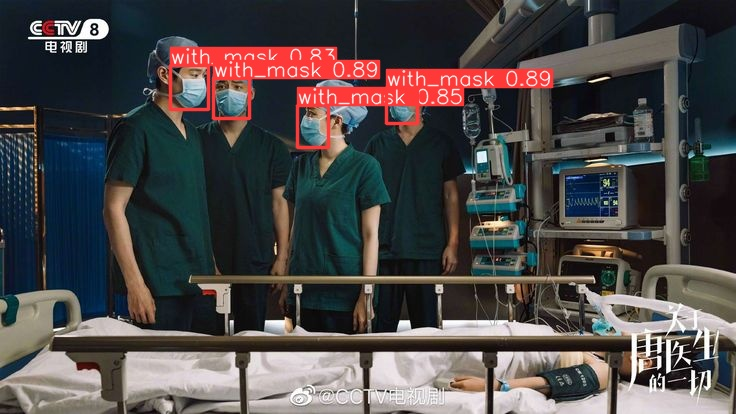

In [ ]:
# Load a model
model = YOLO("/content/drive/MyDrive/2/verihubs/model/yolov8s/weights/best.pt")  # pretrained YOLOv8n model
path_img = '/content/test_img_mask.jpg'
# Predict and display the result
result = model.predict(path_img, imgsz=640, conf=0.2, save=True)
# The result object contains information about the prediction
# You can access the saved image path using result.save_path
image_path = result[0].save_dir + f"/{path_img.split('/')[-1]}"

# Display the image
display(Image(filename=image_path))

## Object Detection on New Images with YOLOv5 (YOLOv5n)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-5-10 Python-3.10.12 torch-2.2.1+cu121 CPU

Fusing layers... 
Model summary: 157 layers, 1763224 parameters, 0 gradients, 4.1 GFLOPs
Adding AutoShape... 


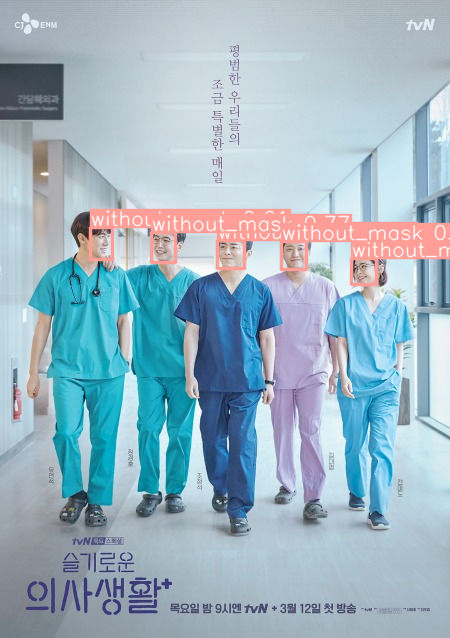

In [ ]:
import torch

# Model
model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/2/verihubs/model/yolov5n/weights/best.pt')

# Images
imgs = ['/content/doctor.jpg']  # batch of images
# Inference
results = model(imgs)

# Results
# results.print()
results.show()  # or .show()

# What's Next ?

## Next Steps for Optimizing Mask Detection Performance

Based on the comprehensive analysis of YOLOv5 and YOLOv8 models for real-time mask detection, we've identified YOLOv8s as the top choice for production deployment due to its balance of speed and accuracy. However, there's always room for improvement, and further exploration can enhance the performance of mask detection systems. Here are some potential next steps to consider:

**1. Fine-tune YOLOv8s for Specific Scenarios:** Tailor YOLOv8s to specific environments and use cases by fine-tuning it with a dataset that reflects the real-world conditions where the system will be deployed. This can involve images and videos from the actual deployment location, considering lighting, background variations, and target demographics.

**2. Explore Data Augmentation Techniques:** Expand the training dataset by applying data augmentation techniques to artificially increase the diversity of data. This can include techniques like flipping, rotating, cropping, and adding noise to the training images, making the model more robust to variations in real-world data.

**3. Investigate Two-stage Approach:** Consider a two-stage approach for mask detection, where YOLOv8s handles initial object detection followed by a more specialized model for a more detailed mask-wearing classification. This could improve the accuracy of "mask_weared_incorrect" detection while maintaining real-time performance.

**4. Evaluate Hardware Optimization:** Explore hardware optimization techniques to further improve inference speed. This could involve using specialized hardware accelerators like GPUs or TPUs or optimizing the model for specific hardware platforms.

**5. Continuously Monitor and Evaluate:** Continuously monitor the performance of the deployed mask detection system in real-world scenarios. Collect feedback from users and gather performance metrics to identify areas for improvement and make adjustments as needed.

By following these steps, you can further optimize the performance of your mask detection system, ensuring its effectiveness in real-world applications and meeting the specific requirements of your target environment. Remember, continuous improvement is key to maintaining a high-performing and reliable mask detection system.